In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys, os
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), '../symlie'))

from misc.viz import plot1d, plot2d
from data.generate_2d import Create2dData
from data.generate_2d import sine1d, sine2d, flower, mnist
from data.generate_data import datasets

In [3]:
def plot_data(dataset, data_kwargs_list = ['data_kwargs'], N_plot=5):
    for data_kwargs in data_kwargs_list:
        create_data = Create2dData(dataset['create_sample_func'], dataset[data_kwargs], dataset['transform_kwargs'])
        out = create_data(N = N_plot)
        x, y = out['x'].reshape(N_plot, *dataset[data_kwargs]['grid_size']), out['y']
        dataset['plot_func'](x, y, l = 3)


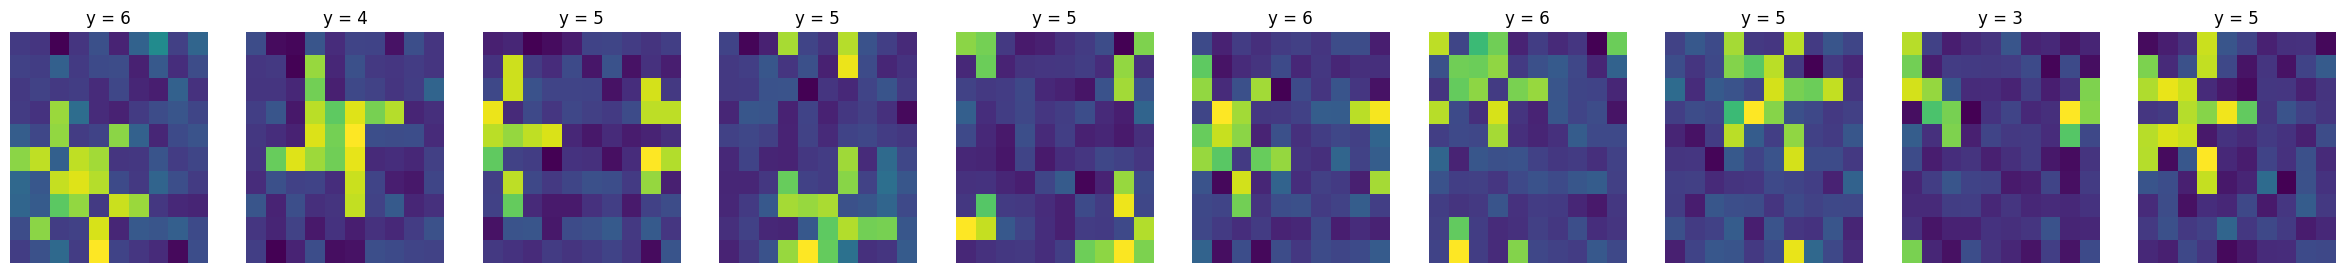

In [22]:
dataset = {
    'create_sample_func' : flower,
    'plot_func'          : plot2d,
    'data_kwargs'        : {'grid_size':(10, 10), 'noise_std':0.1, 'y_low':2, 'y_high':7},
    'transform_kwargs'   : {'eps_mult':[0., 1., 1., 1.], 'only_flip' : False},
}

plot_data(dataset, N_plot=10)

sine2d


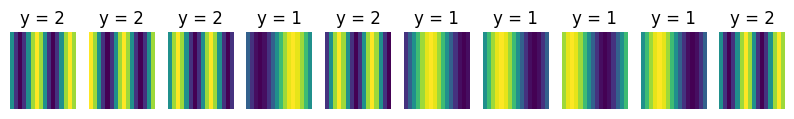

In [7]:
N_plot = 10


data_kwargs_sine1d      = {'grid_size':(1, 7), 'noise_std':0.5, 'y_low':1, 'y_high':3}
transform_kwargs_sine1d = {'eps_mult':[0., 0., 1., 0.], 'only_flip' : False}

data_kwargs_sine2d      = {'grid_size':(7, 7), 'noise_std':0.5, 'y_low':1, 'y_high':3}
data_kwargs_sine2d      = {'grid_size':(16, 16), 'noise_std':0.0, 'y_low':1, 'y_high':3}
transform_kwargs_sine2d = {'eps_mult':[0., 0., 1., 1.], 'only_flip' : False}

data_kwargs_flower      = NotImplemented
transform_kwargs_flower = NotImplemented

data_kwargs_mnist      = {'grid_size':(7, 7), 'noise_std':0.5}
transform_kwargs_mnist = {'eps_mult':[0., 1., 1., 1.], 'only_flip' : False}

datasets = {
    # 'sine1d' : {'create_sample_func' : sine1d, 'plot_func' : plot1d, 'data_kwargs': data_kwargs_sine1d, 'transform_kwargs' : transform_kwargs_sine1d},
    'sine2d' : {'create_sample_func' : sine2d, 'plot_func' : plot2d, 'data_kwargs': data_kwargs_sine2d, 'transform_kwargs' : transform_kwargs_sine2d},
    # 'flower' : {'create_sample_func' : flower, 'plot_func' : plot2d, 'data_kwargs': data_kwargs_sine1d, 'transform_kwargs' : transform_kwargs_sine1d},
    # 'mnist'  : {'create_sample_func'  : mnist, 'plot_func' : plot2d, 'data_kwargs': data_kwargs_mnist, 'transform_kwargs' : transform_kwargs_mnist},
}

for dataset_name, dataset in datasets.items():
    print(dataset_name)

    create_data = Create2dData(dataset['create_sample_func'], dataset['data_kwargs'], dataset['transform_kwargs'])

    out = create_data(N = N_plot)
    x, y = out['x'].reshape(N_plot, *dataset['data_kwargs']['grid_size']), out['y']

    dataset['plot_func'](x, y)

In [ ]:
from torchvision import datasets, transforms
import shutil

def mnist(N: int, split: str, grid_size: tuple[int, int]):
    data_dir = '../data'
    train = {'train': True, 'val': True, 'test':False}[split]
    idx   = {'train': 0, 'val': 50_000, 'test': 0}

    # check if data exists
    if not os.path.exists(os.path.join(data_dir, 'MNIST/raw')):
        datasets.MNIST(data_dir, train=True, download=True)
        datasets.MNIST(data_dir, train=False, download=True)
    dataset = datasets.MNIST(data_dir, train=train, download=False)

    x = dataset.data
    y = dataset.targets
    
    # compose dataset
    compose = transforms.Compose([
            transforms.Normalize((0.1307,), (0.3081,)),
            transforms.Resize((7,7), antialias=True)
    ])
    x = compose(x / 255.)


    i = idx[split]
    assert i + N < len(dataset), f"{i+N} >= {len(dataset)}"
    if split == 'train':
        assert i + N < idx['val'] , f"{i+N} >= {idx['val']}"

    x = x[i:i+N]
    y = y[i:i+N]
    return x, y

x, y = mnist(10, 'test', (7, 7))
x.shape

In [ ]:
plot2d(x, y)

In [ ]:
compose = transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Resize((7,7), antialias=True)
])

compose(x / 255.).shape

In [ ]:
x.shape

In [ ]:
len(dataset_test)

In [ ]:
dataset_train[0][0].shape

In [ ]:
mnist_dir = '../data/mnist2'

In [ ]:
images = np.load(os.path.join(mnist_dir, 'val', 'images.npy'))
images.shape

In [ ]:
plt.imshow(dataset_test[0][0][0])